<a href="https://colab.research.google.com/github/jana-jovicic/Speech-to-Text/blob/master/speech_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jana-jovicic/Speech-to-Text.git

Cloning into 'Speech-to-Text'...
remote: Enumerating objects: 1205, done.
remote: Counting objects: 100% (1205/1205), done.
remote: Compressing objects: 100% (1203/1203), done.
remote: Total 1205 (delta 6), reused 1189 (delta 0), pack-reused 0
Receiving objects: 100% (1205/1205), 25.07 MiB | 20.25 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [0]:
!ls Speech-to-Text

dataset  README.md  speech_to_text.ipynb


In [0]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile 
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout, Input, MaxPooling1D
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
train_path = 'Speech-to-Text' + os.path.sep + 'dataset' + os.path.sep + 'train'
test_path = 'Speech-to-Text' + os.path.sep + 'dataset' + os.path.sep + 'test'

# Explore datatset

Plot amplitude over time of one audio recording:

[ 4.0688968e-04  3.1694559e-05 -4.5456085e-04 ...  5.9469097e-04
  8.1928732e-04  6.3908176e-04]
22050
22050


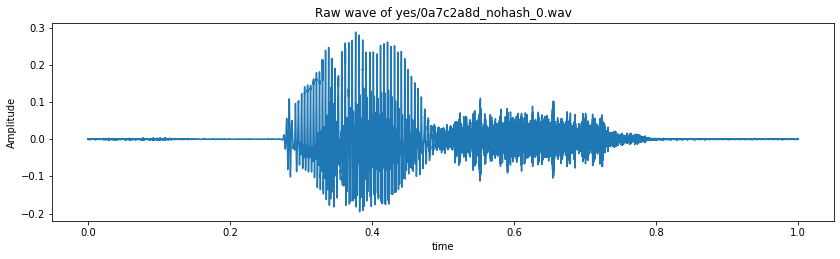

In [15]:
samples, sample_rate = librosa.load(train_path + os.path.sep + 'yes' + os.path.sep + '0a7c2a8d_nohash_0.wav')
print(samples)
print(sample_rate)
print(len(samples))

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [6]:
ipd.Audio(samples, rate=sample_rate)

Extract labels that represent voice comands:

In [7]:
labels = [d for d in os.listdir(train_path) if os.path.isdir(train_path + os.path.sep + d)]
print(labels)

['no', 'cat', 'dog', 'left', 'right', 'yes']


Get number of recordings for each voice command:

{'no': 154, 'cat': 160, 'dog': 150, 'left': 132, 'right': 126, 'yes': 157}


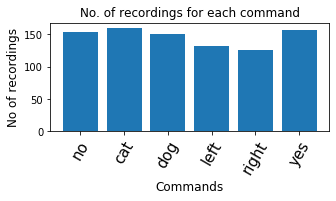

In [8]:
train_num_of_recordings_per_label = {}
for label in labels:
    train_num_of_recordings_per_label[label] = len([f for f in os.listdir(train_path + os.path.sep + label)])
print(train_num_of_recordings_per_label)

#plot
plt.figure(figsize=(5,2))
index = np.arange(len(labels))
plt.bar(index, train_num_of_recordings_per_label.values())
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

{'no': 53, 'cat': 50, 'dog': 50, 'left': 43, 'right': 39, 'yes': 58}


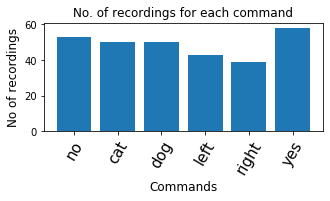

In [9]:
test_num_of_recordings_per_label = {}
for label in labels:
    test_num_of_recordings_per_label[label] = len([f for f in os.listdir(test_path + os.path.sep + label)])
print(test_num_of_recordings_per_label)

#plot
plt.figure(figsize=(5,2))
index = np.arange(len(labels))
plt.bar(index, test_num_of_recordings_per_label.values())
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

Get distribution of the duration of recordings:

(array([  1.,   1.,   4.,   2.,  11.,   6.,   7.,  21.,  16., 810.]),
 array([0.510875 , 0.5597875, 0.6087   , 0.6576125, 0.706525 , 0.7554375,
        0.80435  , 0.8532625, 0.902175 , 0.9510875, 1.       ]),
 <a list of 10 Patch objects>)

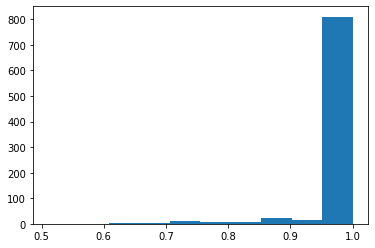

In [10]:
train_duration_of_recordings=[]
for label in labels:
  recordings = [f for f in os.listdir(train_path + os.path.sep + label) if f.endswith('.wav')]
  for record in recordings:
    sample_rate, samples = wavfile.read(train_path + os.path.sep + label + os.path.sep + record)
    # print(sample_rate)   # 16000
    train_duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(train_duration_of_recordings))

(array([  1.,   3.,   0.,   3.,   4.,   3.,   1.,   2.,   4., 272.]),
 array([0.64 , 0.676, 0.712, 0.748, 0.784, 0.82 , 0.856, 0.892, 0.928,
        0.964, 1.   ]),
 <a list of 10 Patch objects>)

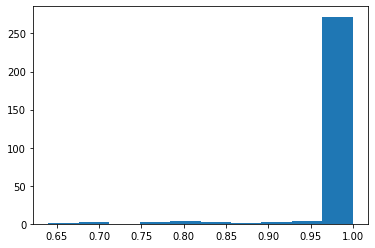

In [11]:
test_duration_of_recordings=[]
for label in labels:
  recordings = [f for f in os.listdir(test_path + os.path.sep + label) if f.endswith('.wav')]
  for record in recordings:
    sample_rate, samples = wavfile.read(test_path + os.path.sep + label + os.path.sep + record)
    # print(sample_rate)   # 16000
    test_duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(test_duration_of_recordings))

# Prepare data for classifiction

In [19]:
# Create arrays of all recordings and corresponding labels. 
all_recordings = []
all_labels = []
for label in labels:
    print(label)
    recordings = [f for f in os.listdir(train_path + os.path.sep + label) if f.endswith('.wav')]
    for record in recordings:
        samples, sample_rate = librosa.load(train_path + os.path.sep + label + os.path.sep + record, sr = 16000)
        # Resample sampling rate to 8000Hz because almost everyone can hear 8,000Hz
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_recordings.append(samples)
            all_labels.append(label)
print(all_labels)

no
cat
dog
left
right
yes
['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'c

In [21]:
# Convert the output labels to integer encoded:
le = LabelEncoder()
y = le.fit_transform(all_labels)
print(y)
classes= list(le.classes_)
print(classes)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [23]:
# convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:
y = to_categorical(y, num_classes=len(labels))
print(y)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [25]:
# Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:
all_recordings = np.array(all_recordings).reshape(-1,8000,1)
print(all_recordings.shape)

(799, 8000, 1)


Split into train and validation set:

In [0]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_recordings), np.array(y), stratify = y, 
                                            test_size = 0.2, random_state = 777, shuffle=True)

# Create model

In [41]:
inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 884, 16)           0     

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [44]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 639 samples, validate on 160 samples
Epoch 1/100
608/639 [===========================>..] - ETA: 0s - loss: 1.7896 - acc: 0.1645
Epoch 00001: val_acc improved from -inf to 0.25000, saving model to best_model.hdf5
639/639 [==============================] - 6s 9ms/sample - loss: 1.7892 - acc: 0.1674 - val_loss: 1.7835 - val_acc: 0.2500
Epoch 2/100
608/639 [===========================>..] - ETA: 0s - loss: 1.7614 - acc: 0.2188
Epoch 00002: val_acc improved from 0.25000 to 0.25625, saving model to best_model.hdf5
639/639 [==============================] - 5s 8ms/sample - loss: 1.7645 - acc: 0.2128 - val_loss: 1.7718 - val_acc: 0.2562
Epoch 3/100
608/639 [===========================>..] - ETA: 0s - loss: 1.7450 - acc: 0.2500
Epoch 00003: val_acc did not improve from 0.25625
639/639 [==============================] - 5s 7ms/sample - loss: 1.7409 - acc: 0.2504 - val_loss: 1.7575 - val_acc: 0.2375
Epoch 4/100
608/639 [===========================>..] - ETA: 0s - loss: 1.7321 - acc: 0.2

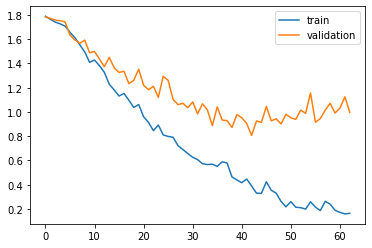

In [45]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='validation') 
plt.legend()
plt.show()